In [1]:
import s3prl
import torch
import numpy
from pydub import AudioSegment
import s3prl.hub as hub
import os
import torchaudio
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import random
import pandas as pd
from torch.utils.data import Dataset,DataLoader
from torch.cuda.amp import autocast
import math

In [2]:
class config:
    seed = 2083
    epoch = 20
    learning_rate = 1e-5
    device = 'cuda'
    input_length = 160000
    model_path = 'model_CNN.pth'

In [3]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(config.seed)

In [4]:
class MYDataset(nn.Module):
    def __init__(self, subset="train"):
        super(MYDataset, self).__init__()
        self.data = []

        if subset == "train":  # 训练集
            npz_path = "../npz/train"
            x_files = os.listdir(npz_path)
            y_data = pd.read_csv("../Data/training-groundtruth.csv", usecols=[0,4])
            y_dict = y_data.set_index('adressfname').to_dict()['dx']

        elif subset == "test":
            npz_path = "../npz/sample"
            x_files = os.listdir(npz_path)
            y_data = pd.read_csv("../Data/sample-groundtruth.csv", usecols=[0,4])
            y_dict = y_data.set_index('adressfname').to_dict()['dx']

        for key, value in y_dict.items():
            if value == 'ProbableAD':
                y_dict[key] = 1.0
            else:
                y_dict[key] = 0.0

            for file_name in x_files:
                file_path = os.path.join(npz_path, file_name)
                x = np.load(file_path)['data']
                x = torch.from_numpy(x)  # 转换成tensor
                # print(x.shape)
                y = y_dict[file_name[:-4]]

                # 切分
                n = math.ceil(x.shape[0] / config.input_length)
                for i in range(n):
                    x_i = x[i * config.input_length : (i + 1) * config.input_length]
                    if x_i.shape[0] != config.input_length:
                        continue
                        """print(x_i.shape[0], config.input_length)
                        x_i = torch.nn.functional.pad(x_i, (0, config.input_length - x_i.shape[0]))"""
                    self.data.append((x_i, y))

    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return len(self.data)


In [ ]:
train_set = MYDataset(subset='train')
test_set = MYDataset(subset='test')

In [ ]:
len(train_set), len(test_set)

In [7]:
print(len(train_set))
print(train_set[25][0].size(), train_set[25][1], train_set[0][0].size(), train_set[0][1])
print(test_set[5][0].size(), test_set[5][1])

4544
torch.Size([160000]) 0.0 torch.Size([160000]) 0.0
torch.Size([160000]) 0.0


In [8]:
class classifier(nn.Module):
    def __init__(self):
        super(classifier, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(160000, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1),
        )

    def forward(self, x):
        output = self.mlp(x)
        return output

In [9]:
class LSTM(nn.Module):
    def __init__(self, input_size=160000, num_layers=2, hidden_size=256, output_size=1):
        """
        LSTM二分类任务
        :param input_size: 输入数据的维度
        :param hidden_layer_size:隐层的数目
        :param output_size: 输出的个数
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers =num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, output_size)
        )


    def forward(self, input_x):
        input_x = input_x.view(len(input_x), 1, -1)
        hidden_cell = (torch.zeros(self.num_layers, input_x.shape[0], self.hidden_size).to('cuda'),
                       torch.zeros(self.num_layers, input_x.shape[0], self.hidden_size).to('cuda'))
                      # shape: (n_layers, batch, hidden_size)


        lstm_out, (h_n, h_c) = self.lstm(input_x, hidden_cell)
        linear_out = self.linear(lstm_out.view(len(input_x), -1))  # =self.linear(lstm_out[:, -1, :])

        return linear_out


In [19]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3)
        self.cnn2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.pool1 =  nn.MaxPool1d(kernel_size=2)
        self.relu1 = nn.ReLU()
        self.cnn3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.pool2 =  nn.MaxPool1d(kernel_size=2)
        self.relu2 = nn.ReLU()
        self.cnn4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3)
        self.pool3 =  nn.MaxPool1d(kernel_size=2)
        self.cnn5 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3)
        self.pool4 =  nn.MaxPool1d(kernel_size=2)
        self.relu3 = nn.ReLU()
        self.adapool = nn.AdaptiveAvgPool1d(1)
        self.linear = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(in_features=512, out_features=512, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=512, out_features=1, bias=True)
        )

    def forward(self, x):
        # print(x.shape)
        x = torch.unsqueeze(x, dim = 1)
        # print(x.shape)
        x = self.cnn1(x)
        # print(x.shape)
        x = self.cnn2(x)
        # print(x.shape)
        x = self.pool1(x)
        x = self.relu1(x)
        # print(x.shape)
        x = self.cnn3(x)
        # print(x.shape)
        x = self.pool2(x)
        x = self.relu2(x)
        # print(x.shape)
        x = self.cnn4(x)
        x = self.pool3(x)
        # print(x.shape)
        x = self.cnn5(x)
        # print(x.shape)
        x = self.pool4(x)
        x = self.relu3(x)
        x = self.adapool(x)
        # print(x.shape)
        x = self.linear(x)
        return x

In [20]:
train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
test_loader = DataLoader(test_set, batch_size=4,shuffle=True)

In [21]:
model = CNN()
# model_0 = getattr(hub, "hubert")()
model.cuda()

CNN(
  (cnn1): Conv1d(1, 32, kernel_size=(3,), stride=(1,))
  (cnn2): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu1): ReLU()
  (cnn3): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu2): ReLU()
  (cnn4): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn5): Conv1d(256, 512, kernel_size=(3,), stride=(1,))
  (pool4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu3): ReLU()
  (adapool): AdaptiveAvgPool1d(output_size=1)
  (linear): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [22]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return (pred == target).float().sum()
def get_likely_index(tensor):

    # find most likely label index for each element in the batch
    return torch.round(torch.sigmoid(tensor))

In [23]:
output = torch.Tensor([0.6157, 0.1404, 0.8154, 0.1813])
a = 20
labels = torch.Tensor([1., 1., 1., 1.])
pred = get_likely_index(output)
b = number_of_correct(pred, labels)
b, a+ b.item()

(tensor(4.), 24.0)

In [24]:
import torch.optim as optim
trainables = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(trainables, lr=config.learning_rate, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3,
                                      gamma=0.4)  # reduce the learning after 20 epochs by a factor of 10
loss_fn = nn.BCEWithLogitsLoss()
n_epoch = config.epoch
best_acc = 0.0

In [25]:
def train(model, epoch):
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(config.device), labels.to(config.device)

        with autocast():
            outputs = model(inputs).squeeze(1)
            loss = loss_fn(outputs, labels)
            # 计算准确率
            pred = get_likely_index(outputs)
            # print(labels, pred, outputs)
            correct = number_of_correct(pred, get_likely_index(labels))


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += correct.item()

    train_acc = epoch_acc / len(train_loader.dataset)
    # print(epoch_acc, len(train_loader.dataset))
    train_loss = epoch_loss / len(train_loader.dataset)
    print("Train Epoch: {} Train Loss: {:.6f} Train Acc: {:.6f}".format(epoch, train_loss, train_acc))

    return train_acc, train_loss


def test(model, epoch):
    epoch_loss = 0
    epoch_acc = 0
    model.eval() # set the model to evaluation mode

    with torch.no_grad():
        for i, data in enumerate(test_loader):
            inputs, labels = data
            inputs, labels = inputs.to(config.device), labels.to(config.device)

            outputs = model(inputs).squeeze(1)
            loss = loss_fn(outputs, labels)
            # 计算准确率
            pred = get_likely_index(outputs)
            correct = number_of_correct(pred, get_likely_index(labels))

            epoch_loss += loss.item()
            epoch_acc += correct.item()


    val_acc = epoch_acc / len(test_loader.dataset)
    val_loss = epoch_loss / len(test_loader.dataset)
    print("Test Epoch: {} Test Loss {:.6f} Test Accuracy: {:.6f}\n".format(epoch, val_loss, val_acc))

    return val_acc, val_loss

In [26]:
train_accs, train_losses, val_accs, val_losses = [], [], [], []

for epoch in range(1, n_epoch + 1):
    train_acc, train_loss = train(model, epoch)
    val_acc, val_loss = test(model, epoch)

    train_accs.append(train_acc), train_losses.append(train_loss)
    val_accs.append(val_acc), val_losses.append(val_loss)

    scheduler.step()
    if val_acc >= best_acc:
        best_acc = val_acc
        torch.save({'epoch': epoch, 'state_dict': model.state_dict()}, config.model_path)
        print('Epoch: {} saving model with Acc {:.3f}'.format(epoch, best_acc))

Train Epoch: 1 Train Loss: 0.171236 Train Acc: 0.570643
Test Epoch: 1 Test Loss 0.173653 Test Accuracy: 0.521739

Epoch: 1 saving model with Acc 0.522
Train Epoch: 2 Train Loss: 0.170753 Train Acc: 0.572403
Test Epoch: 2 Test Loss 0.174165 Test Accuracy: 0.521739

Epoch: 2 saving model with Acc 0.522
Train Epoch: 3 Train Loss: 0.170716 Train Acc: 0.572403
Test Epoch: 3 Test Loss 0.174081 Test Accuracy: 0.521739

Epoch: 3 saving model with Acc 0.522
Train Epoch: 4 Train Loss: 0.170659 Train Acc: 0.572403
Test Epoch: 4 Test Loss 0.174394 Test Accuracy: 0.521739

Epoch: 4 saving model with Acc 0.522
Train Epoch: 5 Train Loss: 0.170674 Train Acc: 0.572403
Test Epoch: 5 Test Loss 0.174559 Test Accuracy: 0.521739

Epoch: 5 saving model with Acc 0.522
Train Epoch: 6 Train Loss: 0.170676 Train Acc: 0.572403
Test Epoch: 6 Test Loss 0.174314 Test Accuracy: 0.521739

Epoch: 6 saving model with Acc 0.522
Train Epoch: 7 Train Loss: 0.170642 Train Acc: 0.572403
Test Epoch: 7 Test Loss 0.174178 Test 

In [27]:
# batch_size = 4 length = 160000  1024 - > 512 - > 1
import matplotlib.pyplot as plt

In [28]:
def plot(train_accs, train_losses, val_accs, val_losses):
    # 绘制 acc 曲线
    plt.figure()
    plt.plot(train_accs, label='Train')
    plt.plot(val_accs, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # 绘制 loss 曲线
    plt.figure()
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

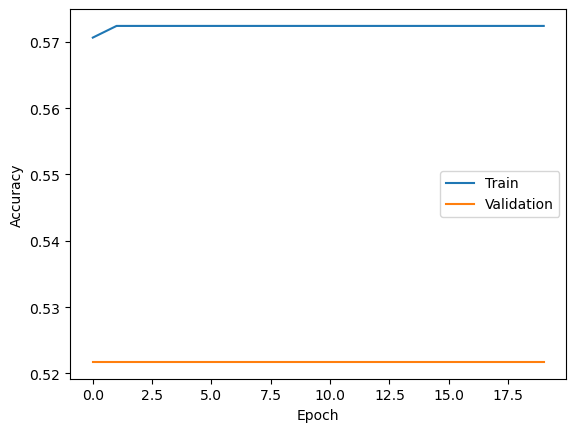

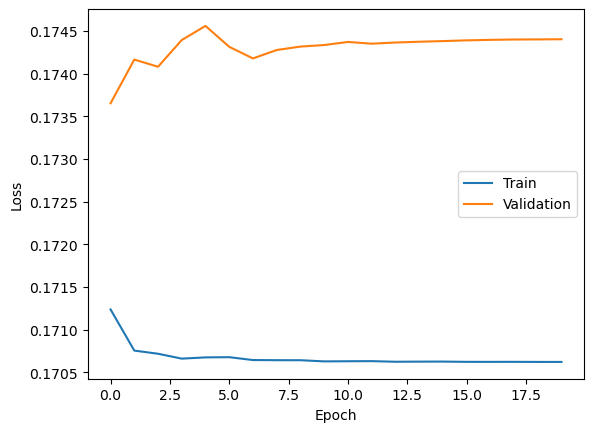

In [29]:
plot(train_accs, train_losses, val_accs, val_losses)

In [ ]:
train_accs, train_losses, val_accs, val_losses